In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # the more advanced python visualization library

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

    # For Classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

    # For Classification
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Date time
from datetime import datetime

# For distrance calculations between long and lat intersections
import math # from haversine import haversine
# Ref.:https://janakiev.com/blog/gps-points-distance-python/

import pickle # for creating pickle file to be used in web app.py

sns.set_style('whitegrid')

# apply style to all the charts
sns.set_style('whitegrid')

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)



### Loading clean Dataset

In [2]:
# Load the data
df = pd.read_csv('declarations-exterminations-punaises-de-lit-1.csv')

Data dictionary:

http://donnees.ville.montreal.qc.ca/dataset/declarations-exterminations-punaises-de-lit/resource/6173de60-c2da-4d63-bc75-0607cb8dcb74

### Verify Datatype and make modifications 

In [3]:
# print(df.dtypes)

In [4]:
# Convert 'DATE_INSP_VISPRE', 'DATE_DEBUTTRAIT', and 'DATE_FINTRAIT'

# Ref.:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
df['DATE_DECLARATION'] = pd.to_datetime(df['DATE_DECLARATION'])
df['DATE_PRIOR_INSP'] = pd.to_datetime(df['DATE_PRIOR_INSP'])
df['DATE_FIRST_EXT'] = pd.to_datetime(df['DATE_FIRST_EXT'])
df['DATE_LAST_EXT'] = pd.to_datetime(df['DATE_LAST_EXT'])

print(df.dtypes)

NO_DECLARATION               int64
DATE_DECLARATION    datetime64[ns]
DATE_PRIOR_INSP     datetime64[ns]
EXT_FREQ                   float64
DATE_FIRST_EXT      datetime64[ns]
DATE_LAST_EXT       datetime64[ns]
HOOD_NUM                    object
HOOD_NAME                   object
BORO_NAME                   object
MTM8_X                     float64
MTM8_Y                     float64
LONGITUDE                  float64
LATITUDE                   float64
LONG_LAT                    object
MTM_X_Y                     object
DEC_MONTH                    int64
DEC_ISSUE                    int64
DATE_DIFF                  float64
dtype: object


#### Dataframe summary

In [5]:
print('Bed bug extermination declarations')
print('')
print('==================COLUMNS==================')
print(df.columns)
print('')
print('==================HEAD==================')
print(df.head())
print('')
print('==================TAIL==================')
print(df.tail())
print('')
print('==================DESCRIBE==================')
print(df.describe())

Bed bug extermination declarations

==================COLUMNS==================
Index(['NO_DECLARATION', 'DATE_DECLARATION', 'DATE_PRIOR_INSP', 'EXT_FREQ',
       'DATE_FIRST_EXT', 'DATE_LAST_EXT', 'HOOD_NUM', 'HOOD_NAME', 'BORO_NAME',
       'MTM8_X', 'MTM8_Y', 'LONGITUDE', 'LATITUDE', 'LONG_LAT', 'MTM_X_Y',
       'DEC_MONTH', 'DEC_ISSUE', 'DATE_DIFF'],
      dtype='object')

==================HEAD==================
   NO_DECLARATION DATE_DECLARATION DATE_PRIOR_INSP  EXT_FREQ DATE_FIRST_EXT  \
0            4254       2012-10-28      2012-09-21      1.00     2012-09-21   
1             830       2011-09-16      2011-07-13      1.00     2011-07-27   
2            1380       2011-11-08      2011-11-02      1.00     2011-11-07   
3             455       2011-08-10      2011-08-09      1.00     2011-08-09   
4            1243       2011-10-26      2011-09-16      1.00     2011-10-05   

  DATE_LAST_EXT HOOD_NUM      HOOD_NAME                            BORO_NAME  \
0    2012-09-21       2

In [6]:
print("df shape:"+str(df.shape) )

df shape:(31241, 18)


In [7]:
df['NO_DECLARATION'].dtype

dtype('int64')

# Feature Engineering

#### Calculate distances between intersections

In [8]:
print('==================TOP_10_BORO==================')
((df.groupby(['BORO_NAME'])
       .agg({'EXT_FREQ': sum, 'NO_DECLARATION':'count'}))
       .sort_values(by = ['EXT_FREQ','NO_DECLARATION'],ascending=False)
       .rename(columns={'EXT_FREQ':'EXT_QT','NO_DECLARATION':'DECL_QT'})
       .head(10))
print('')
print('==================TOP_10_INTERSECTIONS_BASED_ON_EXT_FREQ_AND_ON_DECLARATIONS==================')
((df.groupby(['LONG_LAT','HOOD_NAME','BORO_NAME'])
       .agg({'EXT_FREQ': sum, 'NO_DECLARATION':'count'}))
       .sort_values(by = ['EXT_FREQ','NO_DECLARATION'],ascending=False)
       .rename(columns={'EXT_FREQ':'EXT_QT','NO_DECLARATION':'DECL_QT'})
       .head(10))

==================TOP_10_BORO==================

==================TOP_10_INTERSECTIONS_BASED_ON_EXT_FREQ_AND_ON_DECLARATIONS==================


,,,EXT_QT,DECL_QT
LONG_LAT,HOOD_NAME,BORO_NAME,,
-73.571239_45.584338,Grande-Prairie,Saint-Léonard,352.00,264
-73.68714399999999_45.518173,Grenet,Saint-Laurent,295.00,132
-73.630494_45.509854,Parc-Kent,Côte-des-Neiges–Notre-Dame-de-Grâce,208.00,65
-73.659233_45.569024,Sault-au-Récollet,Ahuntsic-Cartierville,193.00,181
-73.585636_45.527404,Parc-Laurier,Le Plateau-Mont-Royal,189.00,79
-73.600298_45.637873,Marc-Aurèle-Fortin,Rivière-des-Prairies–Pointe-aux-Trembles,181.00,76
-73.61954399999999_45.545823999999996,Crémazie,Villeray–Saint-Michel–Parc-Extension,175.00,73
-73.563652_45.528809,Lorimier,Le Plateau-Mont-Royal,161.00,103
-73.53832299999999_45.543811,Hochelaga,Mercier–Hochelaga-Maisonneuve,161.00,60


Top five Boroughs are Rosemont–La Petite-Patrie, Mercier–Hochelaga-Maisonneuve, Villeray–Saint-Michel–Parc-Extension, Le Plateau-Mont-Royal, and Ville-Marie. 

Top ten intersections are Saint-Léonard, Saint-Laurent, Côte-des-Neiges–Notre-Dame-de-Grâce, Ahuntsic-Cartierville, Rivière-des-Prairies–Pointe-aux-Trembles, Villeray–Saint-Michel–Parc-Extension, Le Plateau-Mont-Royal (2), Mercier–Hochelaga-Maisonneuve, and Ville-Marie, based on the extermination and declaration quantities.

While these to top intersections can individually be considered as epicenters, the top intersection in the Plateau-Mont-Royal is chosen as reference for this analysis, where the coordinates are -73.585636_45.527404 (LONG_LAT).

In [9]:
# Inspication for epicenter calculation:
# https://towardsdatascience.com/transforming-categorical-data-for-usability-in-machine-learning-predictions-90459c3fc967?gi=2253c23cb822

# Ref. : https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1    
    
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2    
    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6367 * c
    return km

In [10]:
# Epicenter coordinates
# df['LONG_LAT'== -73.585636_45.527404]
# plat_lat = [45.527404] 
# plat_lon = [-73.585636]

# Create distance column in dataframe, which returns km values
df['EPI_DIST_1'] = haversine_np(
    df['LONGITUDE'],df['LATITUDE'], -73.585636, 45.527404) # Parc-Laurier , Le Plateau-Mont-Royal

df['EPI_DIST_2'] = haversine_np(
    df['LONGITUDE'],df['LATITUDE'], -73.563652, 45.528809) # Lorimier 	Le Plateau-Mont-Royal
    # Distance from interesection (-73.563652, 45.528809) in Lorimier, Le Plateau-Mont-Royal
    
df['EPI_DIST_3'] = haversine_np(
    df['LONGITUDE'],df['LATITUDE'], -73.659233, 45.569024) # Sault-au-Récollet 	Ahuntsic-Cartierville
    # Distance from interesection (-73.659233, 45.569024) in Sault-au-Récollet, Ahuntsic-Cartierville

df['EPI_DIST_4'] = haversine_np(
    df['LONGITUDE'],df['LATITUDE'], -73.571239, 45.584338) # Grande-Prairie 	Saint-Léonard
    # Distance from interesection (-73.571239, 45.584338) in Grande-Prairie, Saint-Léonard

df['EPI_DIST_5'] = haversine_np(
    df['LONGITUDE'],df['LATITUDE'], -73.68714399999999, 45.518173) # Grenet 	Saint-Laurent 	
    # Distance from interesection (-73.68714399999999, 45.518173) in Grenet, Saint-Laurent 

#### Convert most columns to Integer

In [11]:
# Ref. : https://stackoverflow.com/questions/43956335/convert-float64-column-to-int64-in-pandas
# df['DATE_DIFF'] = df['DATE_DIFF'].astype(np.int64)
# df['EXT_FREQ'] = df['EXT_FREQ'].astype(np.int64)

# # Ref.: https://stackoverflow.com/questions/50863691/pandas-convert-date-object-to-int\
# # df['DATE_DECLARATION'].dt.strftime("%Y%m%d").astype(int)
# # df['DATE_PRIOR_INSP'].dt.strftime("%Y%m%d").astype(int)
# # df['DATE_FIRST_EXT'].dt.strftime("%Y%m%d").astype(int)
# # df['DATE_LAST_EXT'].dt.strftime("%Y%m%d").astype(int)

# # Ref.: https://thispointer.com/python-how-to-convert-datetime-object-to-string-using-datetime-strftime/
# # df['DATE_DECLARATION'] = df['DATE_DECLARATION'].strftime("%Y-%b-%d")

# # Ref.: https://stackoverflow.com/questions/47562634/converting-numpy-datetime64-to-long-integer-and-back
# np.datetime64(np.datetime64(df['DATE_DECLARATION']).astype(long), 'ns')

# df.dtypes

#### Create Month and Year Columns 

In [12]:
#We have this for month and year:

df['DEC_D'] = (pd.DatetimeIndex(df['DATE_DECLARATION']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_DECLARATION']).month).map(str)
    
df['PRIOR_D'] = (pd.DatetimeIndex(df['DATE_PRIOR_INSP']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_PRIOR_INSP']).month).map(str)

df['FIRST_D'] = (pd.DatetimeIndex(df['DATE_FIRST_EXT']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_FIRST_EXT']).month).map(str)

df['LAST_D'] = (pd.DatetimeIndex(df['DATE_LAST_EXT']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_LAST_EXT']).month).map(str)

df['LAST_DM'] = (pd.DatetimeIndex(df['DATE_LAST_EXT']).month).map(str)
df['LAST_DY'] = (pd.DatetimeIndex(df['DATE_LAST_EXT']).year).map(str)

# Create difference between LAST and FIRST Extermination
df['D_DIFF_B'] = round( (df['DATE_LAST_EXT'] - df['DATE_FIRST_EXT'] ) 
                                / np.timedelta64(1,'D') )
    # ['D_DIFF_B'] = ['DATE_LAST_EXT'] - ['DATE_FIRST_EXT']

# Create difference between LAST and FIRST Extermination
df['D_DIFF_C'] = round( (df['DATE_FIRST_EXT'] - df['DATE_PRIOR_INSP'] ) 
                                / np.timedelta64(1,'D') )
    # ['D_DIFF_C'] = ['DATE_FIRST_EXT'] - ['DATE_PRIOR_INSP']

    
# rename column
df['D_DIFF_A'] = df['DATE_DIFF'].copy() 
    # ['D_DIFF_A'] = ['DATE_DECLARATION'] - ['DATE_PRIOR_INSP']

#### Remote unused columns

In [13]:
del df['DEC_MONTH']

del df['HOOD_NUM']
del df['HOOD_NAME']
del df['BORO_NAME']
del df['MTM8_X']
del df['MTM8_Y']
del df['MTM_X_Y']
del df['DEC_ISSUE']

del df['DATE_DIFF']

del df['NO_DECLARATION']
df.dtypes

DATE_DECLARATION    datetime64[ns]
DATE_PRIOR_INSP     datetime64[ns]
EXT_FREQ                   float64
DATE_FIRST_EXT      datetime64[ns]
DATE_LAST_EXT       datetime64[ns]
LONGITUDE                  float64
LATITUDE                   float64
LONG_LAT                    object
EPI_DIST_1                 float64
EPI_DIST_2                 float64
EPI_DIST_3                 float64
EPI_DIST_4                 float64
EPI_DIST_5                 float64
DEC_D                       object
PRIOR_D                     object
FIRST_D                     object
LAST_D                      object
LAST_DM                     object
LAST_DY                     object
D_DIFF_B                   float64
D_DIFF_C                   float64
D_DIFF_A                   float64
dtype: object

### Missing values 

In [14]:
df.isnull().sum()

DATE_DECLARATION    0
DATE_PRIOR_INSP     0
EXT_FREQ            0
DATE_FIRST_EXT      0
DATE_LAST_EXT       0
LONGITUDE           0
LATITUDE            0
LONG_LAT            0
EPI_DIST_1          0
EPI_DIST_2          0
EPI_DIST_3          0
EPI_DIST_4          0
EPI_DIST_5          0
DEC_D               0
PRIOR_D             0
FIRST_D             0
LAST_D              0
LAST_DM             0
LAST_DY             0
D_DIFF_B            0
D_DIFF_C            0
D_DIFF_A            0
dtype: int64

### Additing intersections as columns

In [15]:
# Ref.: https://github.com/arybressane/CEBD1260-BIG-DATA-ANALYTICS

# intersection to numerical columns
# df_inter = pd.get_dummies(df['LONG_LAT'])
# df_model = pd.concat([df, df_inter], axis=1).fillna(0.0)
df_model = df.fillna(0.0)

# print(list(df_inter.columns))
# print('')


In [16]:
# print('================df_model.columns================')
# print(list(df_model.columns))

In [17]:
# Ref.: https://github.com/arybressane/CEBD1260-BIG-DATA-ANALYTICS

# select the columns
    # X input for model
    
X_columns = ['LAST_DM',
                 # Web app text: Month of the last extermination 
                     # (options: 1 thru 12)
             
             'LAST_DY',
                 # Web app text: Year of the last extermination 
                     # (options: 2018 thru 2019)
                         
             'EPI_DIST_1', 
                 # Web app text: Distance from interesection (-73.585636, 45.527404) in Parc-Laurier, Le Plateau-Mont-Royal
                     # (options in km: 2, 4, 8, 10, 12, 14)
             
             'EPI_DIST_4',
                 # Web app text: Distance from interesection (-73.571239, 45.584338) in Grande-Prairie, Saint-Léonard
                     # (options in km: 2, 4, 8, 10, 12, 14)
             
             'EPI_DIST_5'
                 # Web app text: Distance from interesection (-73.68714399999999, 45.518173) in Grenet, Saint-Laurent 
                     # (options in km: 2, 4, 8, 10, 12, 14)

            ] #+ list(df_inter.columns)
    



By using three points as reference on a surface, an estimated location for reference may be deduced. 
Although, as only only increments of 2 km are available for use in the Web App, an inexact location for reference will be used.

In [18]:
# measured output Y
y_column = ['D_DIFF_B']
    # Ref.: http://donnees.ville.montreal.qc.ca/dataset/declarations-exterminations-punaises-de-lit/resource/6173de60-c2da-4d63-bc75-0607cb8dcb74
        # Recall DATE_FINTRAIT [now DATE_LAST_EXT] : Date for the end of the last extermination associated to a declaration

        # ['D_DIFF_B'] = ['DATE_LAST_EXT'] - ['DATE_FIRST_EXT']

                # Web app text: Waiting time (days) since last extermination
        
print(X_columns)

['LAST_DM', 'LAST_DY', 'EPI_DIST_1', 'EPI_DIST_4', 'EPI_DIST_5']


The lead time if an indication if the extermination was successful. 
For a short lead time, and with an assumption that all infestation cases are reported, the extermination are assumed to be successful, since subsequent visits did not occur. This is an assumption.

A minimum threashold is unknown for waiting time.
        

Using regression, use a model in order to determine the features that help determine lead time from the first extermination, in order to determine the recommended waiting duration prior to entering a dwelwing at an intersection where an extermination previously occured. Factors such as the radius from the intersection are not considered in the model.

An alternative regression would entail in determining the number of declarations, although the number of exterminations is capped at four for each declaration. This alternative is not considered in this model. A classification model can be created to determine whether the extermination occured successfully or not with False Positives and True Negatives, as an indicate that an inspection is needed to verify a future reoccurence.

# Model Training

In [19]:
# threshold = 0.8 
# 80% for train, 20% for test

threshold = 0.8

X = df_model[X_columns]
y = df_model[y_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True)

print('==============X_train==============') # X_train
print(X_train.shape)
print(X_train.dtypes)
print('')
print('==============y_train==============') # y_train
print(y_train.shape) 
print(y_train.dtypes)
print('')
print('==============X_test==============') # X_test
print(X_test.shape)
print(X_test.dtypes)
print('')
print('==============y_test==============') # y_test
print(y_test.shape) 
print(y_test.dtypes) 

==============X_train==============
(24992, 5)
LAST_DM        object
LAST_DY        object
EPI_DIST_1    float64
EPI_DIST_4    float64
EPI_DIST_5    float64
dtype: object

==============y_train==============
(24992, 1)
D_DIFF_B    float64
dtype: object

==============X_test==============
(6249, 5)
LAST_DM        object
LAST_DY        object
EPI_DIST_1    float64
EPI_DIST_4    float64
EPI_DIST_5    float64
dtype: object

==============y_test==============
(6249, 1)
D_DIFF_B    float64
dtype: object


### Linear Regression

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print('MAE', round(mae, 2))

#calculate the RMSE
RMAE = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMAE', round(RMAE, 2))

MAE 40.57
RMAE 90.09


#### Create pickle file for Web App

In [21]:
pickle.dump(model, open('linear_regression.pkl','wb'))

### Random Forest 10

In [22]:
model = RandomForestRegressor(10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(model)
print('MAE', mean_absolute_error(y_test, y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('')


pickle.dump(model, open('linear_regression.pkl','wb'))

C:\Users\outpost\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
MAE 34.16445425435773
RMSE 91.38005500437197



#### Create pickle file for Web App

In [23]:
pickle.dump(model, open('Random_Forest_10.pkl','wb'))

Random_Forest_10.pkl will be used for the app.py

# Experiments

In [24]:
# Ref.: https://github.com/arybressane/CEBD1260-BIG-DATA-ANALYTICS/blob/master/week5/regression-house-sklearn-ext-class-version.ipynb

def model_training(model_name, model, X_train, y_train):
    model.fit(X_train, y_train)
    return model
    
def model_prediction(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred

def model_evaluation(model_name, y_test, y_pred):
    print(model_name)
    print('MAE', mean_absolute_error(y_test, y_pred))
    print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('')

def run_experiment(model_name, model, X_train, y_train, X_test):
    train_model = model_training(model_name, model, X_train, y_train)
    predictions = model_prediction(train_model, X_test)
    model_evaluation(model_name, y_test, predictions)
    
run_experiment('Linear Regression', LinearRegression(), X_train, y_train, X_test)
run_experiment('KNN 5', KNeighborsRegressor(5), X_train, y_train, X_test)
run_experiment('KNN 2', KNeighborsRegressor(2), X_train, y_train, X_test)
run_experiment('Decision Tree', DecisionTreeRegressor(), X_train, y_train, X_test)
run_experiment('Random Forest 10', RandomForestRegressor(10), X_train, y_train, X_test)
run_experiment('Random Forest 100', RandomForestRegressor(100), X_train, y_train, X_test)

Linear Regression
MAE 40.566844852623554
RMSE 90.08657286357642

KNN 5
MAE 35.85684109457514
RMSE 92.90322328866523

KNN 2
MAE 36.9400704112658
RMSE 101.32154543280033

Decision Tree
MAE 36.75126959019182
RMSE 112.19841505921408



C:\Users\outpost\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Random Forest 10
MAE 34.74222265325481
RMSE 94.66735010006488



C:\Users\outpost\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Random Forest 100
MAE 33.30261714359298
RMSE 89.93822505099699



# Error Analysis

In [25]:
# Ref.: https://github.com/arybressane/CEBD1260-BIG-DATA-ANALYTICS/blob/master/week5/regression-house-sklearn-ext-class-version.ipynb

model = RandomForestRegressor(10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\outpost\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [26]:
#for i in range(len(X_test.columns)):
fi = []
for i, col in enumerate(X_test.columns):
    fi.append([col, model.feature_importances_[i]])
pd.DataFrame(fi).sort_values(1, ascending=False)

,0,1
1,LAST_DY,0.59
3,EPI_DIST_4,0.15
2,EPI_DIST_1,0.13
4,EPI_DIST_5,0.08
0,LAST_DM,0.06


In [27]:
df_test = pd.DataFrame(X_test).copy()
df_test['LT'] = y_test
df_test['prediction'] = y_pred
df_test['abs_error'] = abs(df_test['LT']-df_test['prediction'])
df_test.sort_values(by='abs_error', ascending=False).round()

,LAST_DM,LAST_DY,EPI_DIST_1,EPI_DIST_4,EPI_DIST_5,LT,prediction,abs_error
30527,3,2016,0.00,6.00,8.00,3756.00,47.00,3709.00
5986,12,2016,4.00,11.00,9.00,1461.00,34.00,1428.00
12715,3,2017,3.00,7.00,5.00,1299.00,40.00,1259.00
5249,12,2016,7.00,6.00,7.00,1226.00,33.00,1193.00
2362,10,2015,0.00,6.00,8.00,1188.00,38.00,1150.00
29815,9,2011,9.00,12.00,1.00,0.00,1117.00,1117.00
21032,10,2017,0.00,7.00,8.00,971.00,0.00,971.00
12194,8,2014,3.00,4.00,9.00,832.00,1.00,831.00
11810,2,2017,3.00,4.00,8.00,777.00,15.00,762.00
5960,9,2018,4.00,10.00,5.00,779.00,24.00,755.00


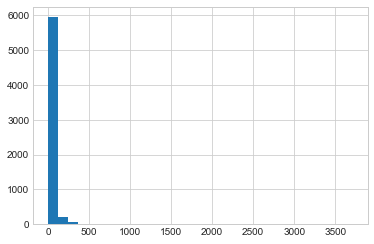

In [28]:
plt.hist(df_test['abs_error'], bins=30)
plt.show()

In [29]:
df_error = df_test[df_test['abs_error']>0]
df_error

,LAST_DM,LAST_DY,EPI_DIST_1,EPI_DIST_4,EPI_DIST_5,LT,prediction,abs_error
16322,6,2013,7.36,5.50,7.80,133.00,76.50,56.50
2167,4,2016,4.11,5.18,11.93,37.00,24.92,12.08
14235,6,2016,8.08,14.38,11.13,0.00,6.90,6.90
30944,8,2013,11.19,6.11,12.72,146.00,24.47,121.53
6208,3,2014,9.84,3.52,14.93,0.00,60.00,60.00
6197,11,2013,12.71,19.12,12.19,22.00,25.20,3.20
8338,10,2012,10.59,16.97,10.14,0.00,8.30,8.30
26171,9,2014,5.90,4.59,7.55,58.00,71.20,13.20
25464,11,2016,4.38,10.60,9.42,0.00,15.15,15.15
18350,11,2015,10.58,5.45,12.40,0.00,46.30,46.30


In [30]:
df_error.describe()

,EPI_DIST_1,EPI_DIST_4,EPI_DIST_5,LT,prediction,abs_error
count,5233.00,5233.00,5233.00,5233.00,5233.00,5233.00
mean,5.09,7.09,8.83,30.51,32.61,40.96
std,3.23,3.73,3.40,94.62,48.55,91.29
min,0.00,0.00,0.00,0.00,0.00,0.03
25%,2.62,4.66,6.73,0.00,7.00,7.75
50%,4.25,6.14,8.93,0.00,17.90,19.40
75%,7.22,8.82,10.90,28.00,39.00,43.80
max,24.56,28.27,24.75,3756.00,1117.30,3708.70


In [ ]:
df_error.corr()['abs_error'].dropna().sort_values()

EPI_DIST_5   -0.04
EPI_DIST_1   -0.01
EPI_DIST_4    0.01
prediction    0.41
LT            0.86
abs_error     1.00
Name: abs_error, dtype: float64

# Cross Validation

In [ ]:
models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
    ('RandomForestRegressor100', RandomForestRegressor(n_estimators=100, n_jobs=4)),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('DecisionTreeRegressor', DecisionTreeRegressor())
]

k = 10
results = {}
for m in models:
     print('MODEL', m[0])
     results[m[0]] = {'mae':[], 'rmse':[]}
     kf = KFold(n_splits=k)
     for train_index, test_index in kf.split(X):
         X_train_k, X_test_k = X.values[train_index], X.values[test_index]
         y_train_k, y_test_k = y.values[train_index], y.values[test_index]
        
         model = m[1]
         model.fit(X_train_k, y_train_k.ravel())
         y_pred = model.predict(X_test_k)
            
         mae = mean_absolute_error(y_test_k, y_pred)
         rmse = np.sqrt(mean_squared_error(y_test_k, y_pred))
            
         results[m[0]]['mae'].append(mae)
         results[m[0]]['rmse'].append(rmse)

MODEL LinearRegression
MODEL RandomForestRegressor10
MODEL RandomForestRegressor100
MODEL KNeighborsRegressor


In [ ]:
for metric in ['mae', 'rmse']:
     values = []
     labels = []
     for model, result_values in results.items():
         for m, v in result_values.items():
             if m == metric:
                 labels.append(model)
                 values.append(v)
                    
     plt.figure(figsize=(12,6))
     plt.title(metric)
     plt.boxplot(values)
     plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
     plt.show()

# Commentary